# Code metrics analysis of [pandas](https://pandas.pydata.org/) code base

This notebooks demonstrates how to use __[codemetrics](https://github.com/elmotec/codemetrics)__ to gain insight on a code base like the one at https://github.com/pandas-dev/pandas.  In addition to __[codemetrics](https://github.com/elmotec/codemetrics)__, one will need to install altair, ipywidgets, jupyterlab, and matplotlib for it to work.

In [1]:
import os
import pathlib as pl
import datetime as dt
import logging

import joblib
import pandas as pd
import altair as alt
from altair.vega.v5 import Vega
from tqdm.auto import tqdm

import codemetrics as cm
import codemetrics.vega

%matplotlib inline

print("pandas version:", pd.__version__)
print("altair version:", alt.__version__)

pandas version: 1.4.1
altair version: 4.2.0


In [2]:
%load_ext autoreload
%autoreload

In [3]:
log = cm.log
logging.basicConfig(format="%(relativeCreated)6d %(level)s %(message)s")
log.setLevel(logging.WARNING)
log.info("logging enabled")

## Setup

Sets up a few useful things:

- define a few useful variables like `analysis_start_date` or the `project` under analysis.
- joblib.Memory to cache some outputs and clearing out the cache when we execute this cell.


In [4]:
# Useful variables
analysis_end_date = dt.datetime.now(tz=dt.timezone.utc)
analysis_start_date = analysis_end_date - dt.timedelta(365)

# Change current directory to the project under being analyzed.
project = cm.GitProject(pl.Path().absolute() / ".." / ".." / "pandas")

# Sets up caching and wipes out cache if any.
disk = joblib.Memory(location=os.getenv("TEMP"), verbose=0)
get_cloc = disk.cache(cm.get_cloc)
get_cloc.clear()

## Lines of code (loc)

Leverage cloc to count the lines of code and infer some basic information about the languages used in this project.

In [5]:
cloc_program = "cloc.exe"
loc = cm.get_cloc(project, cloc_program=cloc_program).query("language != 'SUM'")

In [6]:
loc.head(3)

,language,path,blank,comment,code
0,SVG,doc/source/_static/schemas/04_plot_overview.svg,1,1,6441
1,HTML,pandas/tests/io/data/html/banklist.html,33,21,4832
2,Python,pandas/core/generic.py,1792,6215,4181


In [7]:
loc_sum = (
    loc.groupby("language")
    .sum()
    .reset_index()
    .melt(id_vars=["language"])
    .rename(columns={"variable": "type", "value": "lines"})
)
significant_languages = loc.groupby("language").sum().code.nlargest(10).index.tolist()
loc_sum_sl = loc_sum.query("language in @significant_languages")
loc_sl = loc.query("language in @significant_languages")
alt.Chart(loc_sum_sl).mark_bar().encode(
    x=alt.X("lines:Q"),
    y=alt.Y(
        "language:N",
        sort=alt.EncodingSortField(field="lines", op="sum", order="descending"),
    ),
    color=alt.Color("type:N", scale=alt.Scale(scheme="accent")),
    tooltip=["lines:Q", "type:O"],
).properties(title="Lines of code")

alt.Chart(...)

## Retrieve git log data

Now that we know what the code base looks like today, we turn our attention to history and build a data frame of the git log history for the past year. 

We then calculate the age of each file and generate a graph of recent changes as well as a circle visualization of the code base. 

In [8]:
log = cm.get_log(project, after=analysis_start_date)
log["issue"] = log["message"].str.extract(r"\(#(\d+)\)")
log = pd.merge(log, loc[["path"]], left_on="path", right_on="path")

In [9]:
log.head(2)

,revision,author,date,path,message,kind,action,textmods,propmods,copyfromrev,copyfrompath,added,removed,issue
0,1bd193eeba,Daniel Schmidt,2022-02-17 23:21:41+00:00,.github/workflows/code-checks.yml,fix broken Docker image build (#45889),f,NaN,True,False,<NA>,<NA>,24.0,0.0,45889
1,ce8fae0d05,Torsten WÃ¶rtwein,2022-01-22 17:06:32+00:00,.github/workflows/code-checks.yml,CI: bump type checker versions (#45461),f,NaN,True,False,<NA>,<NA>,1.0,1.0,45461


A first analysis that can be done is to see how often the often the code changes by visualizing the number of changes each week and the frequency of the changes. Note that the graphs will show the actual numbers when you hover on the bars and the circle if you actually run the notebook in Jupyter.

In [10]:
ages = log[["date", "path"]].merge(loc_sl)
df = (
    ages.sample(5000, random_state=42)  # altair supports a maximum of 5000 data points.
    .assign(
        age=lambda x: (analysis_end_date - x["date"]).dt.total_seconds() / 86400
    )  # Altair does not handle TimeDelta64.
    .assign(
        week=lambda x: x.date.dt.tz_localize(None).dt.to_period(freq="W").dt.end_time
    )  # Compute the end of the week for that change.
)

In [11]:
df.head()

,date,path,language,blank,comment,code,age,week
3411,2021-09-12 19:11:14+00:00,doc/source/whatsnew/v1.4.0.rst,reStructuredText,225,182,686,158.241041,2021-09-12 23:59:59.999999999
9629,2021-03-12 02:33:29+00:00,pandas/core/arrays/sparse/dtype.py,Python,72,158,184,342.933923,2021-03-14 23:59:59.999999999
2303,2021-03-12 02:33:29+00:00,pandas/core/arrays/boolean.py,Python,73,88,222,342.933923,2021-03-14 23:59:59.999999999
6883,2021-03-16 11:14:49+00:00,pandas/core/internals/array_manager.py,Python,223,308,842,338.571886,2021-03-21 23:59:59.999999999
6792,2021-09-14 12:35:17+00:00,pandas/tests/tools/test_to_datetime.py,Python,351,273,2141,156.516007,2021-09-19 23:59:59.999999999


In [12]:
width = 1000
chart = alt.Chart(df).encode(color="language")
top = (
    chart.mark_bar(size=15)
    .encode(
        x=alt.X("week:T", sort="ascending", title="week of"),
        y=alt.Y("count(path):Q", title="Count of files changed"),
        color="language:N",  # alt.Color('language', scale=alt.Scale(scheme=None)),
        tooltip=["count(path)", "language"],
    )
    .properties(width=width, title="Number of changes each week")
)
bottom = (
    chart.mark_tick(thickness=2, opacity=0.1)
    .encode(x=alt.X("date:T"), tooltip="path")
    .properties(width=width, title="Frequency of changes")
)
alt.vconcat(top, bottom)

alt.VConcatChart(...)

Another perspective is to see how old is each file to get a sense of what has not been touched for a while.  The stronger the blue tint is, the older the file is. The size of the circle is proportional to the nuber of line in the file.

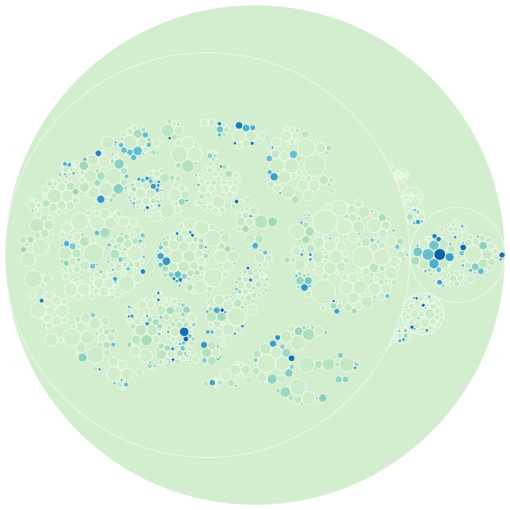

In [13]:
ages = cm.get_ages(log).merge(loc_sl)
desc = cm.vega.vis_ages(ages, height=500, width=500)
Vega(desc)

## Complexity

On to complexity calculation. Here we calculate the complexity of the current code base, file by file,
function by function so it could take a little long. We run it on .py files only and we leverage tqdm to
show a progress bar.

In [14]:
# Get Python file with the most recent revision
python_df = (
    log[["path", "date"]]
    .groupby("path", as_index=False)
    .max()
    .query("path.str.endswith('.py')")
    .merge(log[["path", "date", "revision"]])
    .assign(path=lambda x: x["path"].astype("string"))
)
# Progress bar for pandas
tqdm.pandas(desc="calculating complexity")
# Calculates complexity on python files.
complexity = (
    python_df[["revision", "path"]]
    .groupby(["revision", "path"])
    .progress_apply(cm.get_complexity, project=project)
)

calculating complexity:   0%|          | 0/1089 [00:00<?, ?it/s]

In [15]:
# Calculates 80% percentile of complexity for each file
path_complexity = (
    complexity.reset_index()[["path", "cyclomatic_complexity", "token_count"]]
    .groupby("path")
    .quantile(0.8)
    .sort_values(by="cyclomatic_complexity", ascending=False)
    .reset_index()
    .rename(columns={"cyclomatic_complexity": "complexity"})
)
# Merge to lines of code.
loc_cc = pd.merge(loc, path_complexity)

# Hot spots

Hot spots are files that exhibit high complexity __and__ changed a lot recently. This is typically where you will find bugs.

The graph below will show files harboring complexity as large circle while an increased number of change will make the color trend from yellow to more red shades.

In [16]:
hspots = cm.get_hot_spots(log.head(1), loc_cc.head(1))

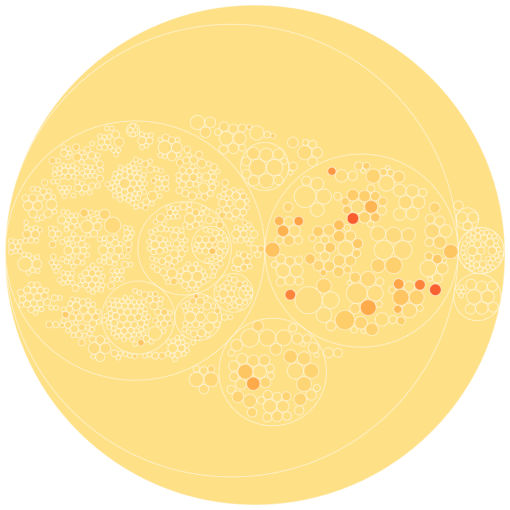

In [17]:
hspots = cm.get_hot_spots(log, loc_cc.assign(path=lambda x: x["path"].astype("string")))
hspots.query("language == 'Python'").sort_values(
    by=["changes", "complexity"], ascending=False
).head()
desc = cm.vega.vis_hot_spots(hspots, width=500, height=500, size_column="complexity")
Vega(desc)

## Co-changes or inter-file coupling

Co-changes builds on the idea that files or functions that change together imply a hidden dependency and may need refactoring.

We calculate how often each file change in relation to the other and display high level of coupling. Again, we focus on the files that have changed a lot recently.

In [18]:
co_changes = (
    cm.get_co_changes(log, by="path", on="issue")
    .query("(coupling > .6) & (changes > 20)")
    .sort_values(by=["changes", "cochanges"], ascending=False)
)
co_changes

,path,dependency,changes,cochanges,coupling
28262,pandas/core/indexes/multi.py,pandas/core/indexes/base.py,96,62,0.645833
27476,pandas/core/indexes/datetimelike.py,pandas/core/indexes/base.py,58,37,0.637931
28035,pandas/core/indexes/interval.py,pandas/core/indexes/base.py,46,30,0.652174
27212,pandas/core/indexes/category.py,pandas/core/indexes/base.py,45,28,0.622222
27861,pandas/core/indexes/extension.py,pandas/core/indexes/base.py,35,24,0.685714
72579,pandas/tests/io/formats/style/test_html.py,pandas/io/formats/style.py,24,18,0.750000
21627,pandas/core/arrays/timedeltas.py,pandas/core/arrays/datetimes.py,24,15,0.625000
19744,pandas/core/arrays/integer.py,pandas/core/arrays/floating.py,22,17,0.772727
19579,pandas/core/arrays/floating.py,pandas/core/arrays/integer.py,21,17,0.809524
48931,pandas/tests/dtypes/test_inference.py,pandas/_libs/lib.pyx,21,15,0.714286


## File level analysis

It can also be useful to dive into the complexity history of one particular file or function. Let's consider the following file and calculate historical complexity of each function in the file. 

In [19]:
path = "pandas/core/frame.py"
func_df = log[log["path"] == path][["date", "revision", "path"]]
func_df.head()

,date,revision,path
3573,2022-02-11 14:30:38+00:00,70e4c5b105,pandas/core/frame.py
3574,2022-02-09 00:29:01+00:00,1b454487b7,pandas/core/frame.py
3575,2022-02-01 00:02:12+00:00,9a98aca4b5,pandas/core/frame.py
3576,2022-01-30 23:51:34+00:00,ae67cb7322,pandas/core/frame.py
3577,2022-01-30 23:49:04+00:00,de6607c156,pandas/core/frame.py


In [20]:
func_cplx_df = func_df.groupby(["revision", "path"]).progress_apply(
    cm.get_complexity, project=project
)

calculating complexity:   0%|          | 0/228 [00:00<?, ?it/s]

In [21]:
func_cpx_df = pd.merge(func_df, func_cplx_df.reset_index(), on=["revision", "path"])
top_cpx_func_df = (
    func_cpx_df.groupby("name")[["cyclomatic_complexity"]]
    .mean()
    .astype("float")
    .dropna()
    .nlargest(10, "cyclomatic_complexity")
)
top_cpx_func_df.nlargest(3, "cyclomatic_complexity")
filt_func_cpx_df = func_cpx_df[func_cpx_df["name"].isin(set(top_cpx_func_df.index))]
filt_func_cpx_df.head()

,date,revision,path,function,cyclomatic_complexity,nloc,token_count,name,long_name,start_line,end_line,top_nesting_level,length,fan_in,fan_out,general_fan_out,file_tokens,file_nloc
1,2022-02-11 14:30:38+00:00,70e4c5b105,pandas/core/frame.py,1,34,165,793,__init__,"__init__( self , data = None , index : Axes | ...",592,805,1,214,0,0,0,25235,8722
31,2022-02-11 14:30:38+00:00,70e4c5b105,pandas/core/frame.py,31,27,91,548,to_dict,"to_dict( self , orient : str = ""dict"" , into =...",1771,1969,1,199,0,0,0,25235,8722
34,2022-02-11 14:30:38+00:00,70e4c5b105,pandas/core/frame.py,34,32,166,591,from_records,"from_records( cls , data , index = None , excl...",2078,2284,1,207,0,0,0,25235,8722
35,2022-02-11 14:30:38+00:00,70e4c5b105,pandas/core/frame.py,35,17,128,371,to_records,"to_records( self , index = True , column_dtype...",2286,2447,1,162,0,0,0,25235,8722
50,2022-02-11 14:30:38+00:00,70e4c5b105,pandas/core/frame.py,50,20,40,338,__getitem__,"__getitem__( self , key )",3477,3542,1,66,0,0,0,25235,8722


In [22]:
alt.Chart(filt_func_cpx_df).mark_line().encode(
    x="date:T",
    y="cyclomatic_complexity:Q",
    color="name:N",
    tooltip=["name", "revision"],
)

alt.Chart(...)

To be continued...